# CS231a PSET 4 Problem 3: Linear Kalman Filter with a Learned Inverse Observation Model

Building on the idea of learning useful representations for downstream tasks we saw in the last problem, in this problem you will see how this can be done for the task of monocular depth estimation.

**Using a GPU**. Make sure to first change your runtime to use a GPU: click Runtime -> Change runtime type -> Hardware Accelerator -> GPU and your Colab instance will automatically be backed by GPU compute.

Note: there is a known issue of the RAM running out while loading the second set of data after training. To get around this, after training please just restart the runtime and rerun the first 3 cells (prior to loading the training data) followed by the cells under 'Using the model'.

In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the data
# folder from the pset folder
# e.g. 'cs231a/ps4'
FOLDERNAME = 'problem_set_4/p3/'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
%cd $FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive
/content/drive/My Drive/problem_set_4/p3


In [2]:
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow.compat.v1 as tf1
tf1.disable_eager_execution()

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
import gc
import time

# Loading the data for part A

Let's start by loading our datasets into memory:


In [3]:
def load_dataset(root, split="train"):
    labels = np.load(root + 'Q3A_positions_'+split+'.npy')
    num_images = labels.shape[0]
    images = np.empty(shape=(num_images, 480, 640,3))
    for i in tqdm(range(num_images), desc='Loading data'):
        im = Image.open(root + 'img_%03d_%s.png'%(i,split))
        images[i] = np.array(im)/255.0
    return images, labels

image_train, label_train = load_dataset('data/Q3A_data/training_set/', 'train')
image_test, label_test = load_dataset('data/Q3A_data/testing_set/', 'test')

Loading data:   0%|          | 0/1000 [00:00<?, ?it/s]

Loading data:   0%|          | 0/100 [00:00<?, ?it/s]

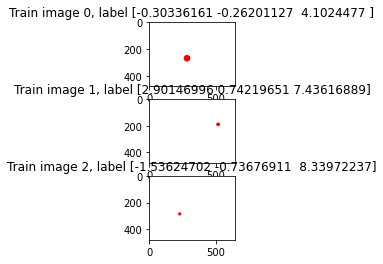

In [4]:
n = 3
fig, axs = plt.subplots(n)
for i in range(n):
    idx = i
    img = image_train[idx]
    axs[i].imshow(img)
    axs[i].set_title('Train image %d, label %s'%(idx,str(label_train[idx])))

# Training the Model

Next, we can go ahead and train the model:

In [3]:
def make_model(input):
    conv1_1 = tf1.keras.layers.Conv2D(32,3, padding='same')(input)
    conv1_1 = tf1.keras.layers.BatchNormalization()(conv1_1)
    conv1_1 = tf1.nn.relu(conv1_1)
    conv1_2 = tf1.keras.layers.Conv2D(32,3, padding='same')(conv1_1)
    conv1_2 = tf1.keras.layers.BatchNormalization()(conv1_2)
    conv1_2 = tf1.nn.relu(conv1_2)
    pool_1 = tf1.nn.max_pool(conv1_2, [1,2,2,1], [1,2,2,1], padding='SAME')
    conv2_1 = tf1.keras.layers.Conv2D(64,3, padding='same')(pool_1)
    conv2_1 = tf1.keras.layers.BatchNormalization()(conv2_1)
    conv2_1 = tf1.nn.relu(conv2_1)
    conv2_2 = tf1.keras.layers.Conv2D(64,3, padding='same')(conv2_1)
    conv2_2 = tf1.keras.layers.BatchNormalization()(conv2_2)
    conv2_2 = tf1.nn.relu(conv2_2)
    pool_2 = tf1.nn.max_pool(conv2_2, [1,2,2,1], [1,2,2,1], padding='SAME')
    conv3_1 = tf1.keras.layers.Conv2D(128,3, padding='same')(pool_2)
    conv3_1 = tf1.keras.layers.BatchNormalization()(conv3_1)
    conv3_1 = tf1.nn.relu(conv3_1)
    conv3_2 = tf1.keras.layers.Conv2D(128,3, padding='same')(conv3_1)
    conv3_2 = tf1.keras.layers.BatchNormalization()(conv3_2)
    conv3_2 = tf1.nn.relu(conv3_2)
    conv3_3 = tf1.keras.layers.Conv2D(128,3, padding='same')(conv3_2)
    N, H, W, C = conv3_3.shape
    features = tf1.reshape(tf1.transpose(conv3_3, [0, 3, 1, 2]), [-1, H * W])
    softmax = tf1.nn.softmax(features)
    # Reshape and transpose back to original format.
    softmax = tf1.transpose(tf1.reshape(softmax, [-1, C, H, W]), [0, 2, 3, 1])
    softmax = tf1.expand_dims(softmax, -1)
    # Convert image coords to shape [H, W, 1, 2]
    posx, posy = tf1.meshgrid(tf1.lin_space(-1., 1., num = H), 
                             tf1.lin_space(-1., 1., num = W), 
                             indexing='ij')
    posx = tf1.reshape(posx, [H, W, 1])
    posy = tf1.reshape(posy, [H, W, 1])
    image_coords = tf1.stack([posx, posy], axis=-1)
    # image_coords = tf1.expand_dims(image_coords, 2)
    feature_points = tf1.reduce_sum(softmax * image_coords, reduction_indices=[1, 2])
    feature_points = tf1.reshape(feature_points, [-1, C * 2])
    # feature_points = tf.contrib.layers.spatial_softmax(conv3_3)
    fc1 = tf1.keras.layers.Dense(64)(feature_points)
    fc1 = tf1.keras.layers.BatchNormalization()(fc1)
    fc1 = tf1.nn.relu(fc1)
    fc2 = tf1.keras.layers.Dense(64)(fc1)
    fc2 = tf1.keras.layers.BatchNormalization()(fc2)
    fc2 = tf1.nn.relu(fc2)
    fc3 = tf1.keras.layers.Dense(3)(fc2)
    return fc3

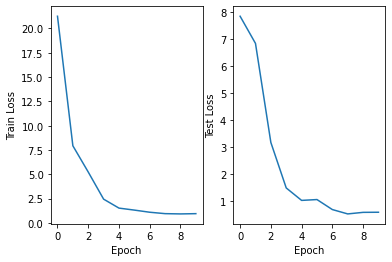

Final training loss:  0.9459299
Final testing loss:  0.5851323


In [6]:
def make_optimizer(pred, label):
    loss = tf1.reduce_mean(tf1.reduce_sum((pred-label)**2, axis=-1))
    optimizer = tf1.train.AdamOptimizer(learning_rate=3e-4).minimize(loss)
    return loss, optimizer

input = tf1.placeholder(shape=[None, 480, 640, 3], dtype=tf1.float32)
label = tf1.placeholder(shape=[None, 3], dtype = tf1.float32)
predict = make_model(input)
loss, optimizer = make_optimizer(predict, label)
saver = tf1.train.Saver()

batch_size = 16
num_epochs = 10

sess=tf1.compat.v1.Session()
sess.run(tf1.global_variables_initializer())
train_losses = []
test_losses = []
for i in tqdm(range(num_epochs), desc='Training'):
    train_index = np.random.permutation(label_train.shape[0])
    current = 0

    losses = []
    while current < label_train.shape[0]:
        batch_image_train = image_train[train_index[current:min(current+batch_size, label_train.shape[0])]]
        batch_label_train = label_train[train_index[current:min(current+batch_size, label_train.shape[0])]]
        loss_val, _ = sess.run([loss, optimizer], feed_dict={input:batch_image_train, label:batch_label_train})
        losses.append(loss_val)
        current = min(current+batch_size, label_train.shape[0])
    train_losses.append(np.mean(losses))

    test_index = np.random.permutation(label_test.shape[0])
    current = 0
    losses = []
    while current < label_test.shape[0]:
        batch_image_test = image_test[test_index[current:min(current+batch_size, label_test.shape[0])]]
        batch_label_test = label_test[test_index[current:min(current+batch_size, label_test.shape[0])]]
        loss_val = sess.run(loss, feed_dict={input:batch_image_test, label:batch_label_test})
        losses.append(loss_val)
        current = min(current+batch_size, label_test.shape[0])
    test_losses.append(np.mean(losses))

    saver.save(sess, 'trained_model')
    if i > 1:
      clear_output()
      fig, (ax1, ax2) = plt.subplots(1, 2)
      ax1.plot(train_losses)
      ax2.plot(test_losses)
      ax1.set_xlabel('Epoch')
      ax1.set_ylabel('Train Loss')
      ax2.set_xlabel('Epoch')
      ax2.set_ylabel('Test Loss')
      plt.show()
print("Final training loss: ", train_losses[-1])
print("Final testing loss: ", test_losses[-1])

In [7]:
%xdel image_train
%xdel image_test
gc.collect()

40547

# Using the Model

Now, let's use the model to make predictions for our Kalman Filter. Note that you may have to restart the runtime if your RAM runs out; just run the things up to 'Loading the data for part A' and then skip to this section. 

In [3]:
def load_dataset():
    labels = np.load('./data/Q3B_data/Q3B_positions_gt.npy')
    num_images = labels.shape[0]
    images = np.empty(shape=(num_images, 480, 640,3))
    for i in tqdm(range(num_images),desc="Loading data"):
        im = Image.open('./data/Q3B_data/img_%03d.png'%(i))
        images[i] = np.array(im)/255.0
    return images, labels

image_infer, label_infer = load_dataset()

Loading data:   0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
tf1.reset_default_graph()

sess=tf1.Session()
input = tf1.placeholder(shape=[1, 480, 640, 3], dtype=tf1.float32)
predict = make_model(input)
saver = tf1.train.Saver()
sess.run(tf1.global_variables_initializer())
saver.restore(sess, 'trained_model')

predictions_val = []
for img in image_infer:
    pred_val = sess.run(predict, feed_dict={input:img[None]})
    predictions_val.append(pred_val[0])
predictions_val = np.array(predictions_val)
print('Mean error: '+str(np.mean(np.linalg.norm(label_infer-predictions_val, axis=1))))
np.save('Q3B_predictions.npy', predictions_val)

Instructions for updating:
Colocations handled automatically by placer.


Mean error: 0.24713695428357904


In [7]:
%xdel image_infer
gc.collect()

22

In [4]:
def load_dataset():
    labels = np.load('./data/Q3D_data/Q3D_positions_gt.npy')
    num_images = labels.shape[0]
    images = np.empty(shape=(num_images, 480, 640,3))
    for i in tqdm(range(num_images),desc="Loading data"):
        im = Image.open('./data/Q3D_data/img_%03d.png'%(i))
        images[i] = np.array(im)/255.0
    return images, labels

image_infer, label_infer = load_dataset()

Loading data:   0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
tf1.reset_default_graph()

sess=tf1.Session()
input = tf1.placeholder(shape=[1, 480, 640, 3], dtype=tf1.float32)
predict = make_model(input)
saver = tf1.train.Saver()
sess.run(tf1.global_variables_initializer())
saver.restore(sess, 'trained_model')

predictions_val = []
for img in image_infer:
    pred_val = sess.run(predict, feed_dict={input:img[None]})
    predictions_val.append(pred_val[0])
predictions_val = np.array(predictions_val)
print('Mean error: '+str(np.mean(np.linalg.norm(label_infer-predictions_val, axis=1))))
np.save('Q3D_predictions.npy', predictions_val)

Instructions for updating:
Colocations handled automatically by placer.


Mean error: 0.741371402748473


# Finishing Problem 3
Now that you have the predictions .npy files, you can use these along with the completed code in p3.py to generate the plots needed for the PDF report. Congratulations on nearing the end of the last 231a PSET!